# Tutorial: What types of data does featurebyte handle?

## Prerequisites:
* Docker installed with beta testing environment
* Featurebyte config file customized
* Featurebyte feature store has been created

In [ ]:
import featurebyte
from featurebyte import *
from featurebyte.config import Configurations
from featurebyte.api.data import Data
from featurebyte.api.change_view import ChangeView

# get the Featurebyte configuration path so that we can edit it
config = Configurations()
print(config.config_file_path)

import pandas as pd
from datetime import datetime

print(featurebyte.version)

## Supported Tabular Column Types
The FeatureByte library is designed for tabular data, and supports the following data warehouse column types:
* INT
* FLOAT
* VARCHAR
* BINARY
* BOOLEAN
* DATE
* TIMESTAMP

## Introduction to the French grocery dataset

This tutorial uses the French grocery dataset that has been pre-installed in the Snowflake beta-testing environment. It consists of 4 data tables recording grocery purchasing activity for each customer.

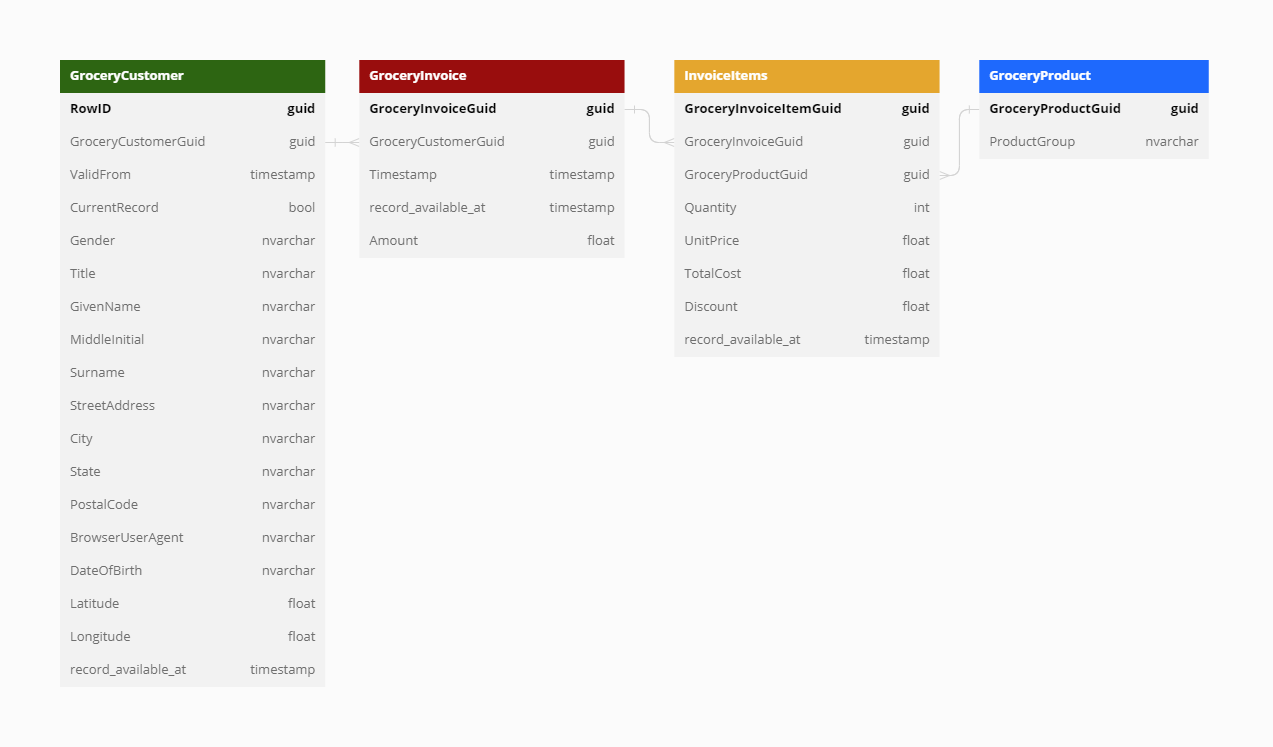

In [ ]:
# tell Featurebyte we are using the beta testing data
Configurations.use_profile("beta_grocery")

# connect to the feature store
fs = FeatureStore.get("beta_user_featurestore")
fs

In [ ]:
# view the databases the feature store can access
fs.list_databases()

In [ ]:
# view the schemas in the BETA_TESTING_DATASETS feature store
fs.list_schemas(database_name="BETA_TESTING_DATASETS")

In [ ]:
# view the tables available in the GROCERY schema
display(fs.list_tables(database_name="BETA_TESTING_DATASETS", schema_name="GROCERY"))

## Preview source data tables

In [ ]:
# show column statistics for a source table
db_table = fs.get_table(database_name="BETA_TESTING_DATASETS", schema_name="GROCERY", table_name="GROCERYCUSTOMER")
db_table.describe()

In [ ]:
# show sample rows from a source table
display(db_table.sample())

## Registering event data

Event data are tables containing information about the timing and attributes of an event.

In featurebyte, an event data must have:
* an event ID, typically the primary key of the table
* a timestamp i.e. when the event occurred

Optionally, an event data can have a second timestamp that records when a data row was created in the data warehouse. Since data warehouses are not used for real-time data, data row creation will typically occur with a delay after the event occurs.

The French grocery dataset contains GroceryInvoice, which is event data. We will now register this data table.

In [ ]:
# show the column names and types for grocery invoice
display(fs.get_table(database_name="BETA_TESTING_DATASETS", schema_name="GROCERY", table_name="GROCERYINVOICE").dtypes)

In [ ]:
# check whether the data is already registered
if not Data.list().name.str.contains("GROCERYINVOICE").any():
    # register GroceryInvoice as an event data
    GroceryInvoice = EventData.from_tabular_source(
        name="GROCERYINVOICE",
        event_id_column="GroceryInvoiceGuid",
        event_timestamp_column="Timestamp",
        record_creation_date_column="record_available_at",
        tabular_source=fs.get_table(
            database_name="BETA_TESTING_DATASETS",
            schema_name="GROCERY",
            table_name="GROCERYINVOICE"
        )
    )
    GroceryInvoice.save(conflict_resolution="retrieve")
else:
    GroceryInvoice = Data.get("GROCERYINVOICE")

Event data requires a feature job setting. This tells featurebyte how often the data in the table is updated, and therefore when to run the feature store cache updates.<BR><BR>
If you have provided a record creation timestamp, you can ask featurebyte to automatically set the feature job setting.

In [ ]:
GroceryInvoice.create_new_feature_job_setting_analysis()

If no record creation timestamp was provided, or if different settings are required, feature job settings can be manually declared.

In [ ]:
# choose more conservative settings - tell featurebyte that the GroceryInvoice event data is updated 1.5 minutes after the end of each hour, and may miss data from the last 145 seconds of each hour
GroceryInvoice.update_default_feature_job_setting(
    FeatureJobSetting(
        blind_spot="145",
        frequency="60m",
        time_modulo_frequency="90s",
    )
)

## Registering item data

Item data are tables containing information about sub-items relating to events.

In featurebyte, an item data must have
* an item ID, typically the primary key of the table
* an event ID, used for joining each row to its parent event
* a parent event table that contains the parent event data

Optionally, an item data can have a second timestamp that records when a data row was created in the data warehouse. Since data warehouses are not used for real-time data, data row creation will typically occur with a delay after the event occurs.

The French grocery data contains InvoiceItems, which is item data. We will now register this data table.

In [ ]:
# show the column names and types for invoice items
display(fs.get_table(database_name="BETA_TESTING_DATASETS", schema_name="GROCERY", table_name="INVOICEITEMS").dtypes)

In [ ]:
# check whether the data is already registered
if not Data.list().name.str.contains("INVOICEITEMS").any():
    InvoiceItems = ItemData.from_tabular_source(
        name="INVOICEITEMS",
        event_id_column="GroceryInvoiceGuid",
        item_id_column="GroceryInvoiceItemGuid",
        event_data_name="GROCERYINVOICE",
        tabular_source=fs.get_table(
            database_name="BETA_TESTING_DATASETS",
            schema_name="GROCERY",
            table_name="INVOICEITEMS"
        )
    )
    InvoiceItems.save(conflict_resolution="retrieve")

## Registering slowly changing data

Slowly changing data are tables containing the status and attributes of an entity. This status does not change often. A new row is created whenever the status or attributes change e.g. when a customer changes their residential address.

In featurebyte, a slowly changing data must have:
* a natural key i.e. a column containing entity values for identifying records. Note that for slowly changing data, in addition to the natural key, record identification also uses at a point in time.
* an effective timestamp i.e. when the entity's status and attribute values first become active
Furthermore, a slowly changing data must have exactly one of the following two columns:
* an end timestamp i.e. when the entity's status and attribute values cease to be active, or
* a current flag i.e. whether the row contains the latest status and attribute values for the entity

Optionally, a slowly changing data can have
* a second timestamp that records when a data row was created in the data warehouse. Since data warehouses are not used for real-time data, data row creation will typically occur with a delay after new values become active.
* a surrogate key i.e. a primary key for the table

The French grocery dataset contains GroceryCustomer, which is slowly changing data. Note that unlike a real-world environment, in this sample data the custoimer values never change. We will now register this data table.

In [ ]:
# show the column names and types for grocery customer
display(fs.get_table(database_name="BETA_TESTING_DATASETS", schema_name="GROCERY", table_name="GROCERYCUSTOMER").dtypes)

In [ ]:
# check whether the data is already registered
if not Data.list().name.str.contains("GROCERYCUSTOMER").any():
    GroceryCustomer = SlowlyChangingData.from_tabular_source(
        name="GROCERYCUSTOMER",
        surrogate_key_column='RowID',
        natural_key_column="GroceryCustomerGuid",
        effective_timestamp_column="ValidFrom",
        current_flag_column ="CurrentRecord",
        record_creation_date_column="record_available_at",
        tabular_source=fs.get_table(
            database_name="BETA_TESTING_DATASETS",
            schema_name="GROCERY",
            table_name="GROCERYCUSTOMER"
        )
    )
    GroceryCustomer.save(conflict_resolution="retrieve")

## Registering dimension data

Dimension data are static tables containing immutable attributes of an entity.

In featurebyte, a dimension data must have:
* a primary key i.e. a column containing entity values for identifying records

Optionally, a dimension data can have a timestamp that records when a data row was created in the data warehouse. Since data warehouses are not used for real-time data, data row creation will typically occur with a delay after the event occurs.

The French grocery dataset contains GroceryProduct, which is dimension data, We will now register this data table.

In [ ]:
# show the column names and types for grocery product
display(fs.get_table(database_name="BETA_TESTING_DATASETS", schema_name="GROCERY", table_name="GROCERYPRODUCT").dtypes)

In [ ]:
# check whether the data is already registered
if not Data.list().name.str.contains("GROCERYPRODUCT").any():
    GroceryProduct = DimensionData.from_tabular_source(
        name="GROCERYPRODUCT",
        dimension_id_column="GroceryProductGuid",
        tabular_source=fs.get_table(
            database_name="BETA_TESTING_DATASETS",
            schema_name="GROCERY",
            table_name="GROCERYPRODUCT"
        )
    )
    GroceryProduct.save(conflict_resolution="retrieve")

## List all registered data


In [ ]:
# display all of the registered data for the French Grocery store schema
Data.list()

## Introduction to the credit card dataset

When you test yourself on what you have learned, you will use the credit card dataset that has been pre-installed in the Snowflake beta-testing environment. It consists of 6 data tables recording credit card transactions of bank customers.

The credit card dataset is stored in the BETA_TESTING_DATASETS database, with schema name CREDIT_CARD

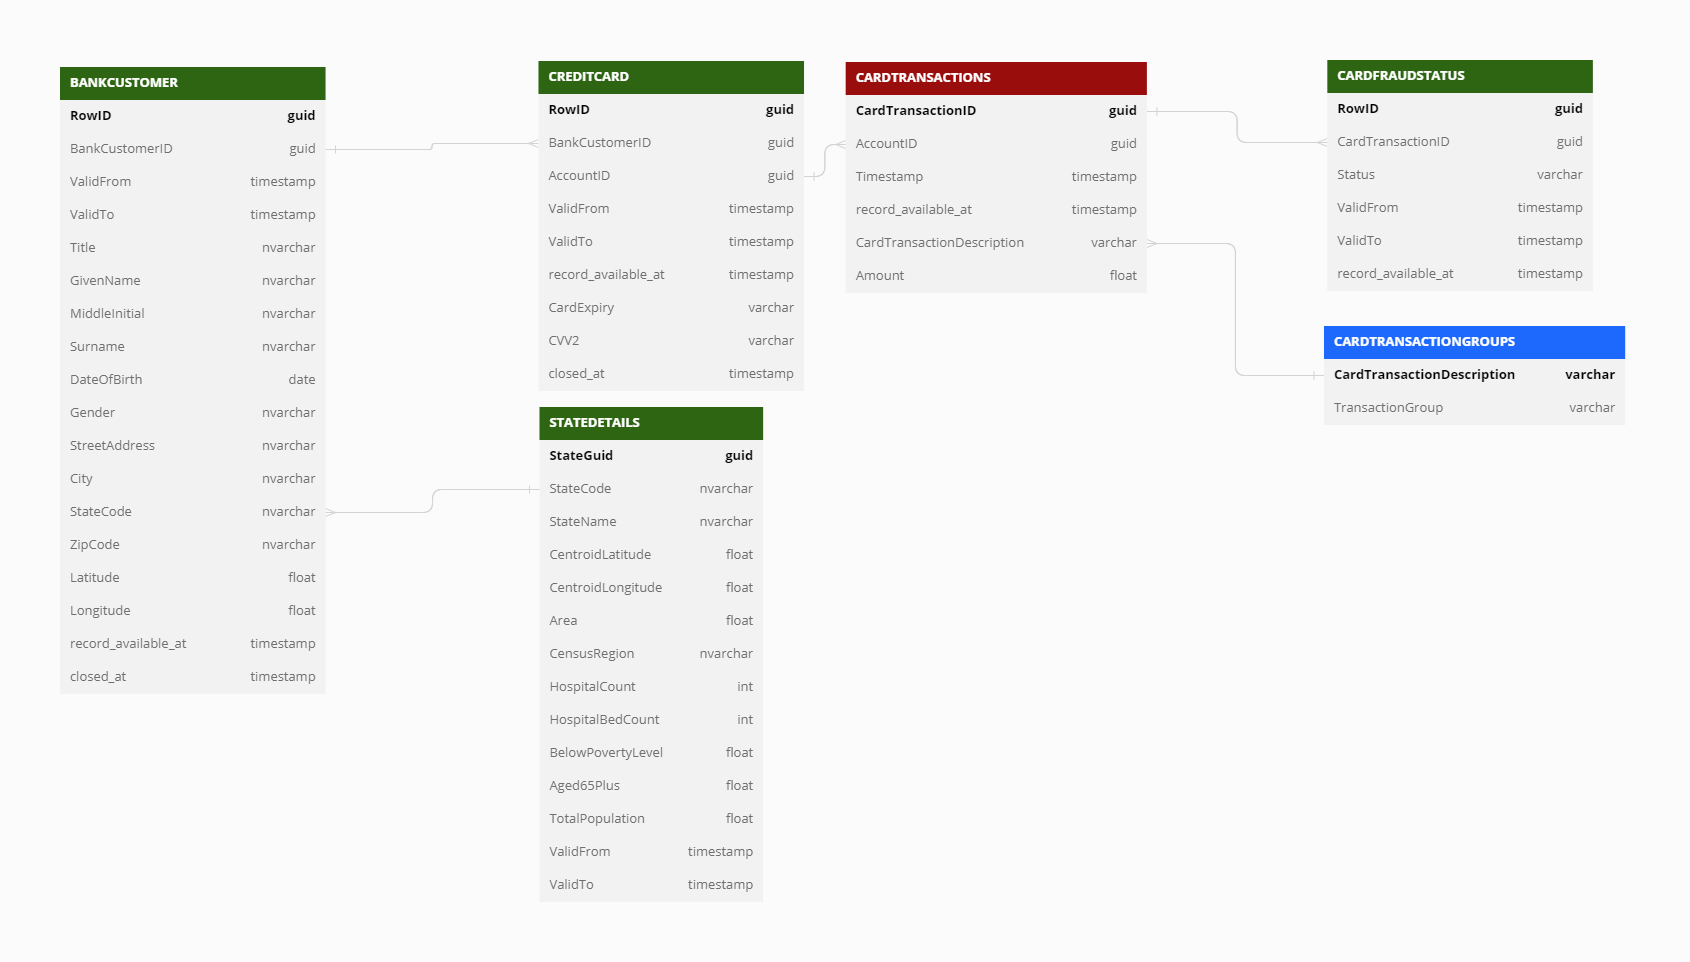

## Test yourself

This is the section of the tutorial where you apply what you have learned to a new dataset, in this case, the credit card dataset.

1) What data type is each of these 6 tables?
2) Register each table

# Tutorial: How do I annotate data?

## Prerequisites:
* Data tables have been registered (see <What types of data does featurebyte handle?> for more information)

## Entities

An entity is a single person, place, or thing about which data can be stored.

In featurebyte, entities are compulsory for joining tables, and form the basis of the unit of analysis.

## Registering entities

Entities are registered at schema level, and later assigned to columns within data tables.

Each entity has a both a name and a serving name. An entity's name is a user-friendly text title, and can contain spaces and special characters. The serving name is a short column name, similar to a database column name, that will be used when serving, requesting, and materializing features.

The French grocery dataset has 4 tables, requiring 3 entities to join them:
1) customer
2) invoice
3) grocery item

Entities are used for more than table joins. Features are declared at an entity level. This tutorial series will suggest two features at state grouping. Therefore the forth entity will be:
1) French state

In [ ]:
# register new entities
entity1 = Entity(name="grocerycustomer", serving_names=["GROCERYCUSTOMERGUID"])
entity1.save(conflict_resolution="retrieve")
entity2 = Entity(name="groceryinvoice", serving_names=["GROCERYINVOICEGUID"])
entity2.save(conflict_resolution="retrieve")
entity3 = Entity(name="groceryproduct", serving_names=["GROCERYPRODUCTGUID"])
entity3.save(conflict_resolution="retrieve")
entity4 = Entity(name="frenchstate", serving_names=["FRENCHSTATE"])
entity4.save(conflict_resolution="retrieve")

# view the entity list
display(Entity.list())

## Annotating which columns represent entities

Each data table will contain one of more columns that represent the entities you just declared.

In [ ]:
# tag the entities for the grocery customer table
groceryCustomerTable = SlowlyChangingData.get('GROCERYCUSTOMER')
# tag columns as entities
groceryCustomerTable.GroceryCustomerGuid.as_entity("grocerycustomer")
groceryCustomerTable.State.as_entity("frenchstate")

# tag the entities for the grocery invoice table
groceryInvoiceTable = EventData.get('GROCERYINVOICE')
# tag columns as entities
groceryInvoiceTable.GroceryInvoiceGuid.as_entity("groceryinvoice")
groceryInvoiceTable.GroceryCustomerGuid.as_entity("grocerycustomer")

# tag the entities for the grocery items table
groceryItemsTable = ItemData.get('INVOICEITEMS')
# tag columns as entities
groceryItemsTable.GroceryInvoiceGuid.as_entity("groceryinvoice")
groceryItemsTable.GroceryProductGuid.as_entity("groceryproduct")

# tag the entities for the grocery product table
groceryProductTable = DimensionData.get('GROCERYPRODUCT')
# tag columns as entities
groceryProductTable.GroceryProductGuid.as_entity("groceryproduct")

## Annotating critical data information

Critical data information used to share information on raw data that needs to be cleaned before being used. This information is centralized at the data source level (Event Data, Item Data, Dimension Data and Slowly Dimension Data) and can be updated over time.

Critical data info and default behaviour how to handle them can be added for:
* missing values (for any data type)
* disguised values (for any data type)
* values not in an expected list (for any data type)
* out of boundaries for numeric values and date type
* string values when numeric values or dates are expected

When users create new features, Views are automatically cleaned based on the information collected in the critical data info to ensure that data is cleaned before feature engineering. They can choose to override the default behaviour by applying a cleaning function with the desired cleaning steps on the raw data.

The French grocery dataset has a column that stores the discount applied to an item purchase. We will annotate the critical data information for that column.

In [ ]:
# update the critical data information in the Discount column of grocery items table

# discount amount cannot be negative
groceryItemsTable.Discount.update_critical_data_info(
    cleaning_operations=[
        MissingValueImputation(imputed_value=0),
        ValueBeyondEndpointImputation(type="less_than", end_point=0, imputed_value=0),
    ]
)

# fix infinite unit price by removing these values
groceryItemsTable.UnitPrice.update_critical_data_info(
    cleaning_operations=[
        ValueBeyondEndpointImputation(type="greater_than", end_point=100000, imputed_value=None),
    ]
)

## Viewing annotations

You can view data annotations, amongst other metadata, using the info function.

In [ ]:
# show the metadata for the grocery items table
display(groceryItemsTable.info())

## Test yourself

This is the section of the tutorial where you apply what you have learned to a new dataset, in this case, the credit card dataset.

1) Which entities are required to join the tables?
2) Register each entity
3) Annotate which columns represent entities

# Tutorial: How do I view tabular data?

## Prerequisites:
* Data tables have been registered (see <What types of data does featurebyte handle?> for more information)

## EDA on source data

Featurebyte supports a describe method, that works similarly to pandas.

In [ ]:
# describe the grocery items table
display(groceryItemsTable.describe())

## What is a view?

As seen in the previous tutorials, Event data, Item data , Dimension Data and Slowly Changing Data are data source objects connected to event, item, dimension and slowly changing dimension tables in the DWH where users can tag entities, annotate the semantics of the data fields, and critical data information. However, users do not use data objects for transformations and feature engineering.

Features are created from an Event View, Item View, Dimension View or Slowly Changing Data View that are transformed views of the Event data, Item Data, Dimension Data and Slowly Changing Data. Users can work directly from a previously published view or create their own view to declare transformations, joins, aggregations, and features. Views columns are automatically cleaned based on the critical data information available.

## Create an event view

EventViews allow users to transform EventData to support the data preparation necessary before creating features.

The French grocery dataset contains GroceryInvoice, which is event data. We will now create an event view from this data table.

In [ ]:
# create an event view for the grocery invoice table
groceryInvoiceView = EventView.from_event_data(event_data = groceryInvoiceTable)

## Create other view types

Similar functions are available to create views from each of the data types.

In [ ]:
# create a slowly changing data view for the grocery customer table
groceryCustomerView = SlowlyChangingView.from_slowly_changing_data(slowly_changing_data = groceryCustomerTable)

# create a dimension data view for the grocery product table
groceryProductView = DimensionView.from_dimension_data(dimension_data = groceryProductTable)

# create an item data view for the grocery items table
groceryItemsView = ItemView.from_item_data(item_data = groceryItemsTable)

Featurebyte also has a ChangeView, a special type of view that converts slowly changing data into event data. Change views can be quite valuable where you wish to join two slowly changing datas, or where the change is just as important as the status.

In [ ]:
# create events for when the customer changes their address
addressChangedView = ChangeView.from_slowly_changing_data(
    scd_data = groceryCustomerTable,
    track_changes_column = "StreetAddress"
    )

# filter out when the past street address is null i.e. we don't want when the very first record was created
addressChangedView = addressChangedView[addressChangedView.past_StreetAddress.isnull() == False]

addressChangedView.sample()

## Display rows from a view

You can display sample rows from a view.

In [ ]:
# display sample rows from the grocery invoice view
display(groceryInvoiceView.sample())

## Test yourself

This is the section of the tutorial where you apply what you have learned to a new dataset, in this case, the credit card dataset.

1) Create a customer view and display sample rows
2) Create a transaction view and display sample rows

# Tutorial: How do I transform data?

In featurebyte, transformations are applied to views, not the source data. The experience and syntax of creating new columns in a view is similar to Pandas.

## Prerequisites:
* Data views have been created (see <How do I view tabular data?> for more information)

## Arithmetic transformations

Supported arithmetic operations include +-*/ and functions such as abs, ceil, exp, floor, log, pow, and sqrt

In [ ]:
# calculate the percentage discount for each grocery item
groceryItemsView["PercentageDiscount"] = groceryItemsView.Discount / (groceryItemsView.TotalCost + groceryItemsView.Discount) * 100.0

groceryItemsView[["Discount", "TotalCost", "PercentageDiscount"]].sample()

## String transformations

The string value of a column is accessed via the str attribute. Supported string operations include:
* concatenation of two string columns
* .str[:n]
* .str.slice()
* .str.len()
* .str.contains

In [ ]:
# check for Windows operating system within the BrowserUserAgent column of the grocery customer view
groceryCustomerView["UsesWindows"] = groceryCustomerView.BrowserUserAgent.str.contains("Windows")

groceryCustomerView[["UsesWindows", "BrowserUserAgent"]].sample()

## Datetime transformations

The datetime value of a column is accessed via the dt attribute. Supported datetime operations include:
* minute, hour, month, year, dayofweek, dayofmonth, hourofweek, dayofyear
* difference between 2 date columns
* increment a date with +timedelta
* inter-event time from an event_timestamp (need entity to be specified)
* lag (the previous record corresponding to the specific entity ID)

In [ ]:
# calculate the inter-event times for each grocery invoice, grouped by customer
ts_col = groceryInvoiceView[groceryItemsView.timestamp_column]
groceryInvoiceView["IET"] = (ts_col - ts_col.lag("GroceryCustomerGuid")).dt.day

groceryInvoiceView.preview()

## Displaying transformation results

To display a transformation result, display the view that it belongs to.

In [ ]:
# display the grocery items view
display(groceryItemsView.sample())

## Supported transformations

Methods:
* abs
* astype
* ceil
* exp
* fillna
* floor
* isnull
* log
* notnull
* pow
* sqrt
* fillna
* minute, hour, month, year, dayofweek, dayofmonth, hourofweek, dayofyear
* inter-event time from an event_timestamp (need entity to be specified)
* lag (the previous record corresponding to the specific entity ID)
* .str[:n] or .str.slice()
* .str.len()
* .str.contains

Operators:
* +, -, * , /
* &, |, ==, !=, <, <=, >, >=
* ~
* concatenate 2 string columns
* difference between 2 date columns
* increment a date with +timedelta

## Test yourself

This is the section of the tutorial where you apply what you have learned to a new dataset, in this case, the credit card dataset.

1) Calculate the population density for each US state
2) Create a flag column for when repayments occur

# Tutorial: How do I filter data?

Featurebyte uses masks in a similar manner to pandas.

## Prerequisites:
* Data views have been created (see <How do I view tabular data?> for more information)

## Masked transformations

The featurebyte way of doing if-then-else transformations is via masks.

In [ ]:
# extract the operating system from the BrowserUserAgent column
groceryCustomerView["OperatingSystem"] = 'Unknown'
mask1 = groceryCustomerView.BrowserUserAgent.str.contains("Windows")
mask2 = groceryCustomerView.BrowserUserAgent.str.contains("Mac OS X")
groceryCustomerView.OperatingSystem[mask1] = 'Windows'
groceryCustomerView.OperatingSystem[mask2] = 'Mac'

groceryCustomerView[["BrowserUserAgent", "OperatingSystem"]].sample()

## Filtered views

You can filter a view via a mask

In [ ]:
# create a view of the customers who are female
mask = groceryCustomerView["Gender"] == "female"
femaleCustomers = groceryCustomerView[mask].copy()

femaleCustomers.sample()

## Test yourself

This is the section of the tutorial where you apply what you have learned to a new dataset, in this case, the credit card dataset.

1) Create a view of transactions showing only the fees charged
2) Assign customers to market segments based upon their age at 31-Dec-2022:
    * under 18
    * 18-65
    * over 65

# Tutorial: How do I join data?

In featurebyte, joins operate on views, not the source data.

## Principles of featurebyte joins

In featurebyte:
* Joins operate on views
* Join criteria are by common entities, and by event dates for joins of event views and slowly changing data
* Similarly to pandas, for the RHS view, the join key must be its index (its natural key).
* Joins add columns to an existing view
* Joins never increase the number of rows in a view.
* By default, the number of rows do not change after a join. However, the number of rows may reduce if an inner join is selected.
* Only one-to-one and many-to-one relationships are supported. One-to-many and many-to-many relationships are not supported.
* Always start with the view that has the <b>many</b> side of the relationship, then join the view that has the <b>one</b> side of the relationship
* Similarly to a left join, rows with no match will contain missing values for the joined fields

## Join slowly changing data to event data

Slowly changing data is joined via the common entities, and the event timestamp. Within the join criteria, the as-at-date for the slowly changing data is the timestamp of the event.

In [ ]:
# Join the grocery customer view with the grocery invoice view
groceryCustomerInvoiceView = groceryInvoiceView.copy()
groceryCustomerInvoiceView.join(groceryCustomerView, on = "GroceryCustomerGuid", rsuffix="_Customer")

groceryCustomerInvoiceView.sample()

## Join event data to item data

Event data is joined to item data via the event ID.

When an ItemView is created, the event_timestamp and the entities of the event data the item data is associated with are automatically added. Featurebyte automatically joins the parent event's entity and timestamp to the item view.

The preferred method to add columns from the event view is the join_event_data_attributes method.

In [ ]:
# copy the invoice amount into the items view
groceryItemsView.join_event_data_attributes(['Amount'], event_suffix='_invoice_total')

groceryItemsView.preview()

## Join dimension data to item data

Dimension data is joined to item data via the entities that they have in common.

In [ ]:
# join the grocery product view with the grocery items view
groceryItemsView.join(groceryProductView, on = "GroceryProductGuid")

groceryItemsView.preview()

## Use an inner join

Inner joins are useful for filtering views because they drop unmatched rows.

In [ ]:
# get a grocery product view
groceryProductView2 = DimensionView.from_dimension_data(dimension_data = groceryProductTable)

# get a grocery items view
groceryItemsView2 = ItemView.from_item_data(item_data = groceryItemsTable)

# create a mask to only include products that have the text "Soda" in the product group
mask = groceryProductView2.ProductGroup.str.contains("Soda")

# apply the mask to the grocery product view
groceryProductView2 = groceryProductView2[mask]

# join the grocery product view with the grocery items view
groceryItemsView2.join(groceryProductView2, how = "inner")

# preview the result
display(groceryItemsView2.preview())

## Supported joins

Not all views can be joined to each other. The diagram below shows which view types can be joined to an existing view. Green indicates a join is possible. Grey indicates a join is not allowed.

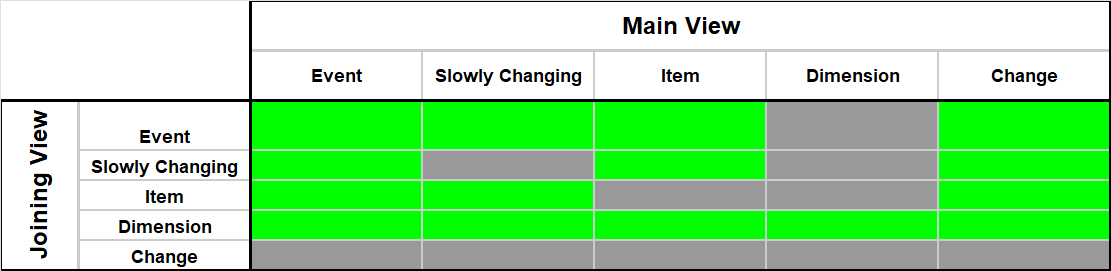

## Joins can be avoided

With featurebyte, you don't always need to join views to get the features you want.

1) <b>Entity relationships:</b> If a feature is calculated from a single table, and the entity level at which is calculated is the same as, or a parent of the entity level of your feature list, then featurebyte will use entity relationships to automatically apply that feature at the level of your feature list. For example, when state code is an entity, if you declare population of a US state as a feature, and your feature list operates at the customer entity level, featurebyte will know to use the state code of the customer to match the state population to the customer.
2) <b>Features built from features:</b> If a feature is calculated from attributes of more than one table, a user can first declare component features from each table, then declare a new feature that is a transformation of the combination of those component features. For example, you could declare a bank customer's income as a feature from the customer table, the average income per capita by US state as a feature from another table, then build a new feature that is the ratio of the bank customer's income to the state average.

## Test yourself

This is the section of the tutorial where you apply what you have learned to a new dataset, in this case, the credit card dataset.

1) Join the CreditCard view to the CardTransactions view
2) Join the CardTransactions view to the CardFraudStatus view
3) Join the CardTransactionGroups view to the CardTransactions view


# Tutorial: How do I aggregate data?

Both tables and entities typically have one-to-many relationships with other tables and entities respectively. Data aggregation is required to align the units of analysis.

All aggregations return feature groups.

There are three types of aggregation:
1) aggregate: aggregation by group
2) aggregate_over: aggregate by group over a time window
3) aggregate_asat: for Slowly Changing Data only, aggregation by group (not the natural key) as at a point in time

Supported aggregation functions:
* AVG: Compute average value
* COUNT: Compute row count
* LATEST: Compute the latest value
* MAX: Compute maximum value
* MIN: Compute minimum value
* NA_COUNT: Compute count of missing values
* STD: Compute standard deviation of values
* SUM: Compute sum of values

## Prerequisites:
* Data views have been created (see <How do I view tabular data?> for more information)

## Aggregation by group

The simplest aggregation is by group and uses the aggregate function.

In [ ]:
# get the sum of the discount amounts for each grocery invoice
totalDiscount = groceryItemsView.groupby("GroceryInvoiceGuid").aggregate(
    "Discount",
    method=AggFunc.SUM,
    feature_name="TotalDiscount",
    fill_value=0
)

# get some invoice IDs and invoice event timestamps from 2022
mask = groceryInvoiceView["Timestamp"].dt.year == 2022
samples = groceryInvoiceView[mask].sample(5)

# create a feature group for the total discount feature
totalDiscountGroup = FeatureGroup([totalDiscount])

# loop through the samples to create a multi-row preview of the feature values
display(pd.concat([totalDiscountGroup.preview(
    point_in_time_and_serving_name={
        "POINT_IN_TIME": samples['Timestamp'][i],
        "GROCERYINVOICEGUID": samples['GroceryInvoiceGuid'][i]
    }
) for i in range(0, 5)]))

## Aggregation over time window

When a data view has timestamps, aggregation can apply across a defined time window.

To aggregate over a time window, use the aggregate_over function.

Window periods are defined using the same format as the Timedelta function in pandas e.g. '7d' is 7 days

In [ ]:
# get the sum of all invoice amounts over the past 90 days for each grocery customer
totalInvoiceAmount = groceryInvoiceView.groupby("GroceryCustomerGuid").aggregate_over(
    "Amount",
    method=AggFunc.SUM,
    feature_names=["TotalInvoiceAmount"],
    fill_value=0,
    windows=['90d']
)

# loop through the samples to create a multi-row preview of the feature values
display(pd.concat([totalInvoiceAmount.preview(
    point_in_time_and_serving_name={
        "POINT_IN_TIME": samples['Timestamp'][i],
        "GROCERYCUSTOMERGUID": samples['GroceryCustomerGuid'][i]
    }
) for i in range(0, 5)]))

## Row counts

There are two types of row counts. The simplest returns a numeric feature.

Note that the aggregate function is only supported for Item views, when the groupby key is the event-id. This is to avoid time leakage. For other cases, use aggregate_over or aggregate_asat (aggregate_asat is currently only available for slowly changing views).

In [ ]:
# get the number of items in each invoice
invoiceItemCount = groceryItemsView.groupby("GroceryInvoiceGuid").aggregate(
    None,
    method=AggFunc.COUNT,
    feature_name="InvoiceItemCount",
    fill_value=0
)

# get the number of invoices for each grocery customer over the past 30 days
invoiceCount30d = groceryInvoiceView.groupby("GroceryCustomerGuid").aggregate_over(
    None,
    method=AggFunc.COUNT,
    feature_names=["InvoiceCount30d"],
    fill_value=0,
    windows=['30d']
)

# loop through the samples to create a multi-row preview of the feature values
display(pd.concat([invoiceCount30d.preview(
    point_in_time_and_serving_name={
        "POINT_IN_TIME": samples['Timestamp'][i],
        "GROCERYCUSTOMERGUID": samples['GroceryCustomerGuid'][i]
    }
) for i in range(0, 5)]))

The second type of row count returns an inventory feature, a json formatted dictionary feature containing the count of each unique value within a group. Note that a featurebyte inventory can be any aggregation statistic, not just counts.

You can access the inventory via the .cd attribute, then apply a count dictionary transformation function.

In [ ]:
# get the inventory of the items purchased over the past 30 days, grouped by customer
inventory = groceryItemsView.groupby("GroceryCustomerGuid", category="GroceryProductGuid").aggregate_over(
    None,
    method=AggFunc.COUNT,
    feature_names=["Inventory"],
    windows=['30d']
)
inventory = inventory["Inventory"]

# get the entropy of the inventory
inventoryEntropy = inventory.cd.entropy()
inventoryEntropy.name = "PurchasedItems30dEntropy"

# create a feature list with both the inventory and the entropy
inventoryFeatures = FeatureGroup([inventory, inventoryEntropy])

# loop through the samples to create a multi-row preview of the feature values
display(pd.concat([inventoryFeatures.preview(
    point_in_time_and_serving_name={
        "POINT_IN_TIME": samples['Timestamp'][i],
        "GROCERYCUSTOMERGUID": samples['GroceryCustomerGuid'][i]
    }
) for i in range(0, 5)]))

## Aggregation as at a point in time

For slowly changing views only, you can aggregate as at a point in time (with an optional time period offset), grouped by an entity.

In [ ]:
# get the average latitude of the customers in each French state, weighted by customer location
meanLatitude = groceryCustomerView.groupby("State").aggregate_asat(
    value_column="Latitude",
    method=AggFunc.AVG,
    feature_name="StateCentroidLatitude"
)
# get the average latitude of the customers in each French state, weighted by customer location
meanLongitude = groceryCustomerView.groupby("State").aggregate_asat(
    value_column="Longitude",
    method=AggFunc.AVG,
    feature_name="StateCentroidLongitude"
)

# combine the two features into a feature group
stateCentroids = FeatureGroup([meanLatitude, meanLongitude])

# loop through the states to create a multi-row preview of the feature values
display(pd.concat([stateCentroids.preview(
    point_in_time_and_serving_name={
        "POINT_IN_TIME": "2023-01-01 00:00:00",
        "FRENCHSTATE": state_name
    }
)  for state_name in ["Alsace", "Aquitaine", "Auvergne", "Basse-Normandie", "Bourgogne", "Bretagne", "Centre", "Champagne-Ardenne", "Corse", "Franche-Comté", "Haute-Normandie", "Île-de-France", "Languedoc-Roussillon", "Limousin", "Lorraine", "Midi-Pyrénées", "Nord-Pas-de-Calais", "Pays de la Loire", "Picardie", "Poitou-Charentes", "Provence-Alpes-Côte d'Azur", "Rhône-Alpes"]]))

Similarly to row counts, you can use the category parameter in the groupby function to get a numeric inventory feature e.g. subtotals of spending by product.

In [ ]:
# calculate subtotals of amount spent on each product, grouped by invoice
invoiceSubtotals = groceryItemsView.groupby("GroceryInvoiceGuid", category="GroceryProductGuid").aggregate(
    "TotalCost",
    method=AggFunc.SUM,
    feature_name="InvoiceSubtotal"
)

# create a feature that is which product was the most expensive share of the invoice
invoiceMaxShare = invoiceSubtotals.cd.most_frequent()
invoiceMaxShare.name = "InvoiceMaxShareItem"

# create a featureGroup to show the inventory and the max product
invoiceFeatures = FeatureGroup([invoiceSubtotals, invoiceMaxShare])
invoiceFeatures = FeatureGroup([invoiceMaxShare])

# loop through the samples to create a multi-row preview of the feature values
display(pd.concat([invoiceFeatures.preview(
    point_in_time_and_serving_name={
        "POINT_IN_TIME": samples['Timestamp'][i],
        "GROCERYINVOICEGUID": samples['GroceryInvoiceGuid'][i]
    }
) for i in range(0, 5)]))

## Test yourself

This is the section of the tutorial where you apply what you have learned to a new dataset, in this case, the credit card dataset.

1) Calculate the number of credit cards a customer has at a point in time
2) Calculate the proportion of transactions that are negative over the past 30 days, grouped by credit card
3) Calculate the entropy of transaction types over the past 90 days, grouped by credit card

# Tutorial: How do I declare features?

## Declare a feature from a column

A feature can be created from a column of view using the as_feature method.

In [ ]:
# use the gender of the customer as a feature
customerGender = groceryCustomerView.Gender.as_feature('customer_gender')

## Declare a feature from an aggregation

Your aggregations are already features. There's no need for any extra steps.

In [ ]:
# declare a feature that is the date of the latest invoice, grouped by customer
latestInvoiceDate = groceryInvoiceView.groupby("GroceryCustomerGuid").aggregate_over(
    "Timestamp",
    method=AggFunc.LATEST,
    windows=[None],
    feature_names=["LatestInvoiceDate"],
)

# declare a feature that is the amount of the latest invoice, grouped by customer
latestInvoiceAmount = groceryInvoiceView.groupby("GroceryCustomerGuid").aggregate_over(
    "Amount",
    method=AggFunc.LATEST,
    windows=[None],
    feature_names=["LatestInvoiceAmount"],
)

# create a feature group with the latest invoice date and amount
latestInvoice = FeatureGroup([latestInvoiceDate, latestInvoiceAmount])

# loop through the samples to create a multi-row preview of the feature values
display(pd.concat([latestInvoice.preview(
    point_in_time_and_serving_name={
        "POINT_IN_TIME": '2023-01-01 00:00:00',
        "GROCERYCUSTOMERGUID": samples['GroceryCustomerGuid'][i]
    }
) for i in range(0, 5)]))

## Declare a feature from other features

A feature can be declared as a transformation of one or more other features. The component features can come from other views or have different entities levels if the entity level of each component feature is the identical or has a parent-child relationship.

In [ ]:
# declare a feature that is an inventory of the items purchased over the past 30 days, grouped by customer
customer_inventory30d = groceryItemsView.groupby("GroceryCustomerGuid", category="GroceryProductGuid").aggregate_over(
    None,
    method=AggFunc.COUNT,
    feature_names=["CustomerInventory30d"],
    windows=['30d']
)

# declare a feature that is an inventory of the items purchased over the past 90 days, grouped by customer
customer_inventory90d = groceryItemsView.groupby("GroceryCustomerGuid", category="GroceryProductGuid").aggregate_over(
    None,
    method=AggFunc.COUNT,
    feature_names=["CustomerInventory90d"],
    windows=['90d']
)

# declare a feature that is an inventory of all customers' items purchased over the past 30 days
all_inventory30d = groceryItemsView.groupby(by_keys=[], category="GroceryProductGuid").aggregate_over(
    None,
    method=AggFunc.COUNT,
    feature_names=["AllInventory30d"],
    windows=['30d']
)

# How consistent is a customer's purchasing behavior over time?
# create a feature that measures the similarity of the past 30 days' purchases versus the past 90 days' purchases
customer_inventory_consistency = customer_inventory30d["CustomerInventory30d"].cd.cosine_similarity(customer_inventory90d["CustomerInventory90d"])
customer_inventory_consistency.name = "CustomerInventory30d90dSimilarity"

# How similar is a customer's purchasing behavior compared to other customers?
# create a feature that measures the similarity of the past 30 days' purchases versus all customers' purchases
customer_inventory_all_similarity = customer_inventory30d["CustomerInventory30d"].cd.cosine_similarity(all_inventory30d["AllInventory30d"])
customer_inventory_all_similarity.name = "CustomerInventory30dAllSimilarity"

# combine these features into a feature group
customer_consistency_similarity = FeatureGroup([customer_inventory_consistency, customer_inventory_all_similarity])

# loop through the samples to create a multi-row preview of the feature values
display(pd.concat([customer_consistency_similarity.preview(
    point_in_time_and_serving_name={
        "POINT_IN_TIME": "2023-01-01 00:00:00",
        "GROCERYCUSTOMERGUID": samples['GroceryCustomerGuid'][i]
    }
) for i in range(0, 5)]))

## Test yourself

This is the section of the tutorial where you apply what you have learned to a new dataset, in this case, the credit card dataset.

1) Create a feature that is the consistency of the past 30 days' transactions versus past 90 days on a credit card
2) Create a feature that is the similarity of the past 30 days' transaction groups for a credit card versus all customers

# Tutorial: How do I declare a target?

In the beta version of featurebyte, you declare a target the same as a feature, with the difference that you often need to materialize the values using a different point in time. The production release of featurebyte will add capabilities to support target declaration via forward aggregates and offset.

## Prerequisites:
* Data views have been created (see <How do I view tabular data?> for more information)

## Declare an event-based target

When the target value is based upon events, aggregation is used.

In [ ]:
# declare a target that is the number of invoices in the next 30 days, grouped by customer

# the horizon is the number of days in the future to predict
horizon = pd.Timedelta('30d')

# the window is the number of days to aggregate for the prediction
window = '30d'

# the target is the number of invoices in the next 30 days, grouped by customer
event_based_target = groceryInvoiceView.groupby("GroceryCustomerGuid").aggregate_over(
    None,
    method=AggFunc.COUNT,
    feature_names=["Target_InvoiceCount"],
    windows=[window]
)

# change from a FeatureGroup to a Feature
event_based_target = event_based_target["Target_InvoiceCount"]

When materializing the target value, remember to add the horizon to the point in time.

In [ ]:
forward_point_in_time = pd.Timestamp('2023-01-01 00:00:00') + horizon
display(forward_point_in_time)

# loop through the samples to create a multi-row preview of the feature values
featureGroup = FeatureGroup([event_based_target])
display(pd.concat([featureGroup.preview(
    point_in_time_and_serving_name={
        "POINT_IN_TIME": forward_point_in_time,
        "GROCERYCUSTOMERGUID": samples['GroceryCustomerGuid'][i]
    }
) for i in range(0, 5)]))

## Declare a status-based target

When the target value is based upon a status, the target is declared from a slowly changing view column.

In [ ]:
# declare a target that is whether the customer account is still open 30 days from now

# the horizon is the number of days in the future to predict
horizon = pd.Timedelta('30d')

# the target is whether there is an active record for the customer 30 days from now
groceryCustomerView['IsActive'] = 1
status_based_target = groceryCustomerView.IsActive.as_feature(feature_name = 'active_customer')

# if no active record then fill with 0
status_based_target.fillna(0)

When materializing the target value, remember to add the horizon to the point in time.

In [ ]:
forward_point_in_time = pd.Timestamp('2023-01-01 00:00:00') + horizon
display(forward_point_in_time)

# create a feature group for materialization
featureGroup = FeatureGroup([status_based_target])

# loop through the samples to create a multi-row preview of the feature values
display(pd.concat([featureGroup.preview(
    point_in_time_and_serving_name={
        "POINT_IN_TIME": forward_point_in_time,
        "GROCERYCUSTOMERGUID": samples['GroceryCustomerGuid'][i]
    }
) for i in range(0, 5)]))

## Test yourself

This is the section of the tutorial where you apply what you have learned to a new dataset, in this case, the credit card dataset.

1) declare a target which is the total transaction amounts over the next 30 days, grouped by customer
2) declare a target which is whether a credit card will have an active record 30 days from now

# Tutorial: How do I align the entity level of features?

A feature list should have features that operate at a coherent entity level i.e. all features must be for the entity that is the unit of analysis, or at an entity that is an attribute of the feature list's entity.

Features at a lower entity level than the use case unit of analysis must be aggregated before inclusion in the feature list.

## View the entity level of a feature

Featurebyte tags every feature with the entities at which it operates. To view the entities, first save each feature.

In [ ]:
# save the features to the feature store

customerGender.save(conflict_resolution="retrieve")
totalInvoiceAmount.save(conflict_resolution="retrieve")
invoiceCount30d.save(conflict_resolution="retrieve")
customer_consistency_similarity.save(conflict_resolution="retrieve")
latestInvoice.save(conflict_resolution="retrieve")
inventoryEntropy.save(conflict_resolution="retrieve")
totalDiscount.save(conflict_resolution="retrieve")
invoiceItemCount.save(conflict_resolution="retrieve")
stateCentroids.save(conflict_resolution="retrieve")
event_based_target.save(conflict_resolution="retrieve")

In [ ]:
# view the entities of each feature
stored_features = Feature.list()
display(stored_features)

In [ ]:
# what is the entity level of the target?
target_entity = stored_features.loc[stored_features.name.str.contains("Target")].entities.values[0][0]
print('The target entity is {}'.format(target_entity))

The use case for the French grocery dataset is to predict the number of invoices in the next 30 days for a customer, so the unit of analysis is the grocerycustomer entity. All features for this use case must be at grocerycustomer entity level, or an entity that is a attribute of the grocerycustomer entity.

In [ ]:
# which features have entities other than the target entity?
def has_other_entities(x, whitelisted):
    for y in x:
        if y != whitelisted:
            return True
    return False
stored_features.loc[[has_other_entities(x, target_entity) for x in stored_features.entities.values]]

State level features are suitable because state is an attribute of customer.
Invoice level features are not suitable because they are not an attribute of customer.

Since groceryinvoice is a lower level entity than the unit of analysis, aggregation is required for the last two of these features. In this tutorial the following aggregations will be applied:
* totalDiscount: aggregation = MAX of past 30 days
* invoiceItemCount: aggregation = LATEST of past 30 days

## Aggregation of features

To aggregate a feature, first add it to a view. Features that are non time based and are extracted from other data views can be added as a column to an event view if one of its columns has been tagged with the same entity as the entity of the features. This is only supported for features with a single entity. If the feature contains multiple entities, an error message will be shown.

To aggregate the invoice-level features to customer-level, first add them to the invoice view.

In [ ]:
# add total discount as a column to the invoice view
groceryInvoiceView.add_feature("TotalDiscount", totalDiscount, entity_column="GroceryInvoiceGuid")

# add invoice item count as a column to the invoice view
groceryInvoiceView.add_feature("InvoiceItemCount", invoiceItemCount, entity_column="GroceryInvoiceGuid")

# show some sample values
groceryInvoiceView.sample()

Next, create higher-level features by aggregating the new view columns, grouped by customer

In [ ]:
# create a feature that is the sum the TotalDiscount column from the invoice view, over 30 days, grouped by customer
maxTotalDiscount30d = groceryInvoiceView.groupby("GroceryCustomerGuid").aggregate_over(
    "TotalDiscount",
    method=AggFunc.MAX,
    feature_names=["MaxTotalDiscount30d"],
    windows=['30d']
)

# create a feature this is the maximum of the InvoiceItemCount column from the invoice view, over 30 days, grouped by customer
latestInvoiceItemCount30d = groceryInvoiceView.groupby("GroceryCustomerGuid").aggregate_over(
    "InvoiceItemCount",
    method=AggFunc.LATEST,
    feature_names=["LatestInvoiceItemCount30d"],
    windows=['30d']
)

# create a feature group for materialization
featureGroup = FeatureGroup([maxTotalDiscount30d, latestInvoiceItemCount30d])

# loop through the samples to create a multi-row preview of the feature values
display(pd.concat([featureGroup.preview(
    point_in_time_and_serving_name={
        "POINT_IN_TIME": "2023-01-01 00:00:00",
        "GROCERYCUSTOMERGUID": samples['GroceryCustomerGuid'][i]
    }
) for i in range(0, 5)]))


## Test yourself

This is the section of the tutorial where you apply what you have learned to a new dataset, in this case, the credit card dataset.

The target is the total transaction amount over the next 30 days, grouped by customer
1) get the entity for each of the following features
* population of the state that the customer lives in
* count of credit cards the customer has used over the past 90 days
* entropy of transaction description groups on transactions over the past 60 days, by customer
* largest single transaction over the past 30 days, by credit card
2) which features require aggregation?
3) apply MAX aggregation, or recode the feature at a different aggregation level, for all features that require aggregation

# Tutorial: How do I declare a feature list?

Feature lists are collections of features with a consistent unit of analysis, for a defined use case. They have statuses, such as "draft" and "production ready".

## Prerequisites:
* Data views have been created (see <How do I view tabular data?> for more information)
* Features have been created (see <How do I aggregate data?> for more information)

## Combine features into a feature list

A feature list is a collection on features, with a feature list name. The code sample below uses the customer-level features created earlier in the tutorial series.

In the beta version, in any of your features are at the parent entity level, the entity ID must be provided. In this example, the state centroid features require the FRENCHSTATE entity ID.

In [ ]:
feature_list_name = 'Beta testing tutorial feature list'
new_feature_list = FeatureList([
    customerGender,
    totalInvoiceAmount,
    invoiceCount30d,
    customer_consistency_similarity,
    latestInvoice,
    inventoryEntropy,
    maxTotalDiscount30d,
    latestInvoiceItemCount30d,
    stateCentroids
    ], name=feature_list_name)

new_feature_list.preview({
    "GROCERYCUSTOMERGUID": "72e934f4-031f-4f00-a0aa-2d9ec1ea0aee",
    "FRENCHSTATE": "Centre",
    "POINT_IN_TIME": "2021-11-07"
})

## Save a feature list

The newly created feature list needs to be saved to the feature store. Note that it is possible that some of the features may already exist in the feature store. The following code selects the option to use the stored feature versions instead of the newly created versions.

In [ ]:
new_feature_list.save(conflict_resolution="retrieve")

In [ ]:
# display all feature lists in the feature store
FeatureList.list()

## Test yourself

This is the section of the tutorial where you apply what you have learned to a new dataset, in this case, the credit card dataset.

Build a feature list that combines these four features:
* population of the state that the customer lives in
* count of credit cards the customer has used over the past 90 days
* entropy of transaction description groups on transactions over the past 60 days, by customer
* largest single transaction over the past 30 days, by customer

# Tutorial: How do I change the status of a feature list?

A feature's readiness indicates its position in its life cycle:
* DEPRECATED
* QUARANTINE
* DRAFT
* PRODUCTION_READY

Similarly, a feature list's status indicates its position in its life cycle:
* DEPRECATED
* DRAFT
* PUBLIC_DRAFT
* PUBLISHED

Both features and feature lists have a default status of draft when they are first created.

## Prerequisites

* A feature list has been defined and saved

## Flag a feature as production ready

In [ ]:
# change the readiness status of each feature in the feature list
for name, feat in new_feature_list.feature_objects.items():
    feat.update_readiness('PRODUCTION_READY')

## Flag a feature list as public draft

This shares the feature list with other users, but also communicates that it is not yet ready for publishing in production

In [ ]:
# make the feature list have published status
new_feature_list.update_status('PUBLIC_DRAFT')

## Deprecate a feature list

When a feature list should not be used, for example, if the data schema or business rules have changed, it should be flagged as deprecated.

In [ ]:
# make a new feature list with the same features as the old one
to_be_deprecated = FeatureList([
        totalDiscount
    ], name='to_be_deprecated')
to_be_deprecated.save(conflict_resolution="retrieve")

# deprecate the new feature list
to_be_deprecated.update_status('DEPRECATED')

In [ ]:
FeatureList.list()

## Test yourself

This is the section of the tutorial where you apply what you have learned to a new dataset, in this case, the credit card dataset.

Using the feature list you created in the test yourself section of the feature list creation tutorial:
1) set each feature readiness to PRODUCTION_READY
2) set the feature list status to PUBLISHED

# Tutorial: How do I create training data?

Your machine learning models need to be trained on historical data. Featurebyte enables you to create training data that will be consistent with the published production AI-ready data pipeline.

## Prerequisites

* A feature list has been defined and saved

## What is a context?

A context defines the circumstances in which features are expected to be materialized. Examples include:
* an active customer that has made at least one purchase over the past 12 weeks
* a transaction reported as suspicious from its report to its case resolution

In the beta-testing phase, a featurebyte user defines a context by providing an observation set i.e. a data frame containing entity values and points in time.

If we were using the French grocery dataset to predict the next 30 days' invoice count, we might define the context as:
* active customers who purchased groceries in the previous 30 days
* predictions are run at 12:01 am on the first day of each calendar month
* we wish to train on recent data, each month from 2022
* no more than 25,000 training examples

In [ ]:
# load a pre-built observation set matching the defined context
observation_set = pd.read_csv("French_grocery_observation_set.csv")
observation_set["POINT_IN_TIME"] = pd.to_datetime(observation_set["POINT_IN_TIME"], utc=True).dt.tz_localize(None)
display(observation_set)

## Materialize historical values

Once you have an observation set, you can request to materialize the historical values for that observation set.

In [ ]:
feature_lists = FeatureList.list()
display(feature_lists.loc[feature_lists.name == new_feature_list.name])

In [ ]:
# materialize the values
training_data = new_feature_list.get_historical_features(observation_set.iloc[0:1000])

# uncomment this next line to get the full training dataset
#training_data = new_feature_list.get_historical_features(observation_set)

# display the training data
display(training_data)

You can add target values to the training data by saving it in a separate feature list, materializing that feature list (remember to offset the point in time), then merging the feature and target values into a single file.

In [ ]:
target_feature_list_name = 'Beta testing tutorial target'
target_feature_list = FeatureList([
    event_based_target
    ], name=target_feature_list_name)
target_feature_list.save(conflict_resolution="retrieve")

target_feature_list.preview({
    "GROCERYCUSTOMERGUID": "72e934f4-031f-4f00-a0aa-2d9ec1ea0aee",
    "FRENCHSTATE": "Centre",
    "POINT_IN_TIME": "2021-12-07"
})

In [ ]:
FeatureList.list()

In [ ]:
# make an observation set for the target
observation_set2 = observation_set.copy()

# offset the point in time by 30 days
observation_set2["POINT_IN_TIME"] = observation_set2["POINT_IN_TIME"] + horizon

# drop the french state column as that entity is not used by the target
observation_set2.drop("FRENCHSTATE", axis=1, inplace=True)

# materialize the values
training_data_target = target_feature_list.get_historical_features(observation_set2.iloc[0:1000])

# uncomment the next line to get the full training target value dataset
#training_data_target = target_feature_list.get_historical_features(observation_set2)

# display the target values
display(training_data_target)

Join the features and the target

In [ ]:
# drop the offset POINT_IN_TIME column from the target value table as it is not needed
training_data_target.drop("POINT_IN_TIME", axis=1, inplace=True)

# join materialized target values to the materialized feature values
training_data = training_data.merge(training_data_target, on="GROCERYCUSTOMERGUID", how="left")

display(training_data)

## Test yourself

This is the section of the tutorial where you apply what you have learned to a new dataset, in this case, the credit card dataset.

Materialize your credit card dataset featurelist from the observation set file credit_card_observation_set.csv

# Tutorial: How do I serve features?

Once you are ready to put your AI-ready data pipeline into production, you need to deploy the feature list and consume it via the featurebyte API.

## Prerequisites

* A feature list has been defined and saved

## Deploy a feature list

To deploy a feature list, call its deploy method.

In [ ]:
FeatureList.list()

In [ ]:
# deploy the new feature list
to_be_deployed = FeatureList.get('Beta testing tutorial feature list')
to_be_deployed.update_status('PUBLISHED')
to_be_deployed.deploy(enable=True, make_production_ready=True)

In [ ]:
# show the deployed feature lists
feature_lists = FeatureList.list()
feature_lists = feature_lists[feature_lists.deployed == True]
feature_lists = feature_lists[~feature_lists.name.str.contains('test yourself')]
display(feature_lists)

In [ ]:
# show the online features
stored_features = Feature.list()
stored_features = stored_features[stored_features.online_enabled == True]

display(stored_features)

## Consume features via API

Once a feature list has been deployed, you can consume it via the feature serving API.

In [ ]:
# features should be online_enabled
to_be_deployed.list_features()

In [ ]:
# get a python template for consuming the feature serving API
to_be_deployed.get_online_serving_code(language="python")

Copy the online serving code that was generated above, paste it into the cell below, then run it

In [ ]:
# replace the contents of this Python code cell with the output from to_be_deployed.get_online_serving_code(language="python")

## Disable a deployment

In [ ]:
# disable the feature list deployment
to_be_deployed.deploy(enable=False)

In [ ]:
# show the deployed feature lists
feature_lists = FeatureList.list()
feature_lists = feature_lists[feature_lists.deployed == True]
display(feature_lists)

## Test yourself

This is the section of the tutorial where you apply what you have learned to a new dataset, in this case, the credit card dataset.

Using the feature list you created in the test yourself section of the feature list creation tutorial:
1) deploy your credit card use case feature list
2) call the API with BankCustomerID = 'a07d302c-17bb-4f57-8272-1e3be8795ad9' and StateCode = 'AK'

# The healthcare dataset

Once you have mastered the tutorial for the grocery dataset and tested yourself on the credit card dataset, you are ready to try the healthcare dataset without guided instructions. This is a more complex dataset with 12 tables.

## Introduction to the healthcare dataset

The healthcare dataset is stored in the BETA_TESTING_DATASETS database, with schema name HEALTHCARE

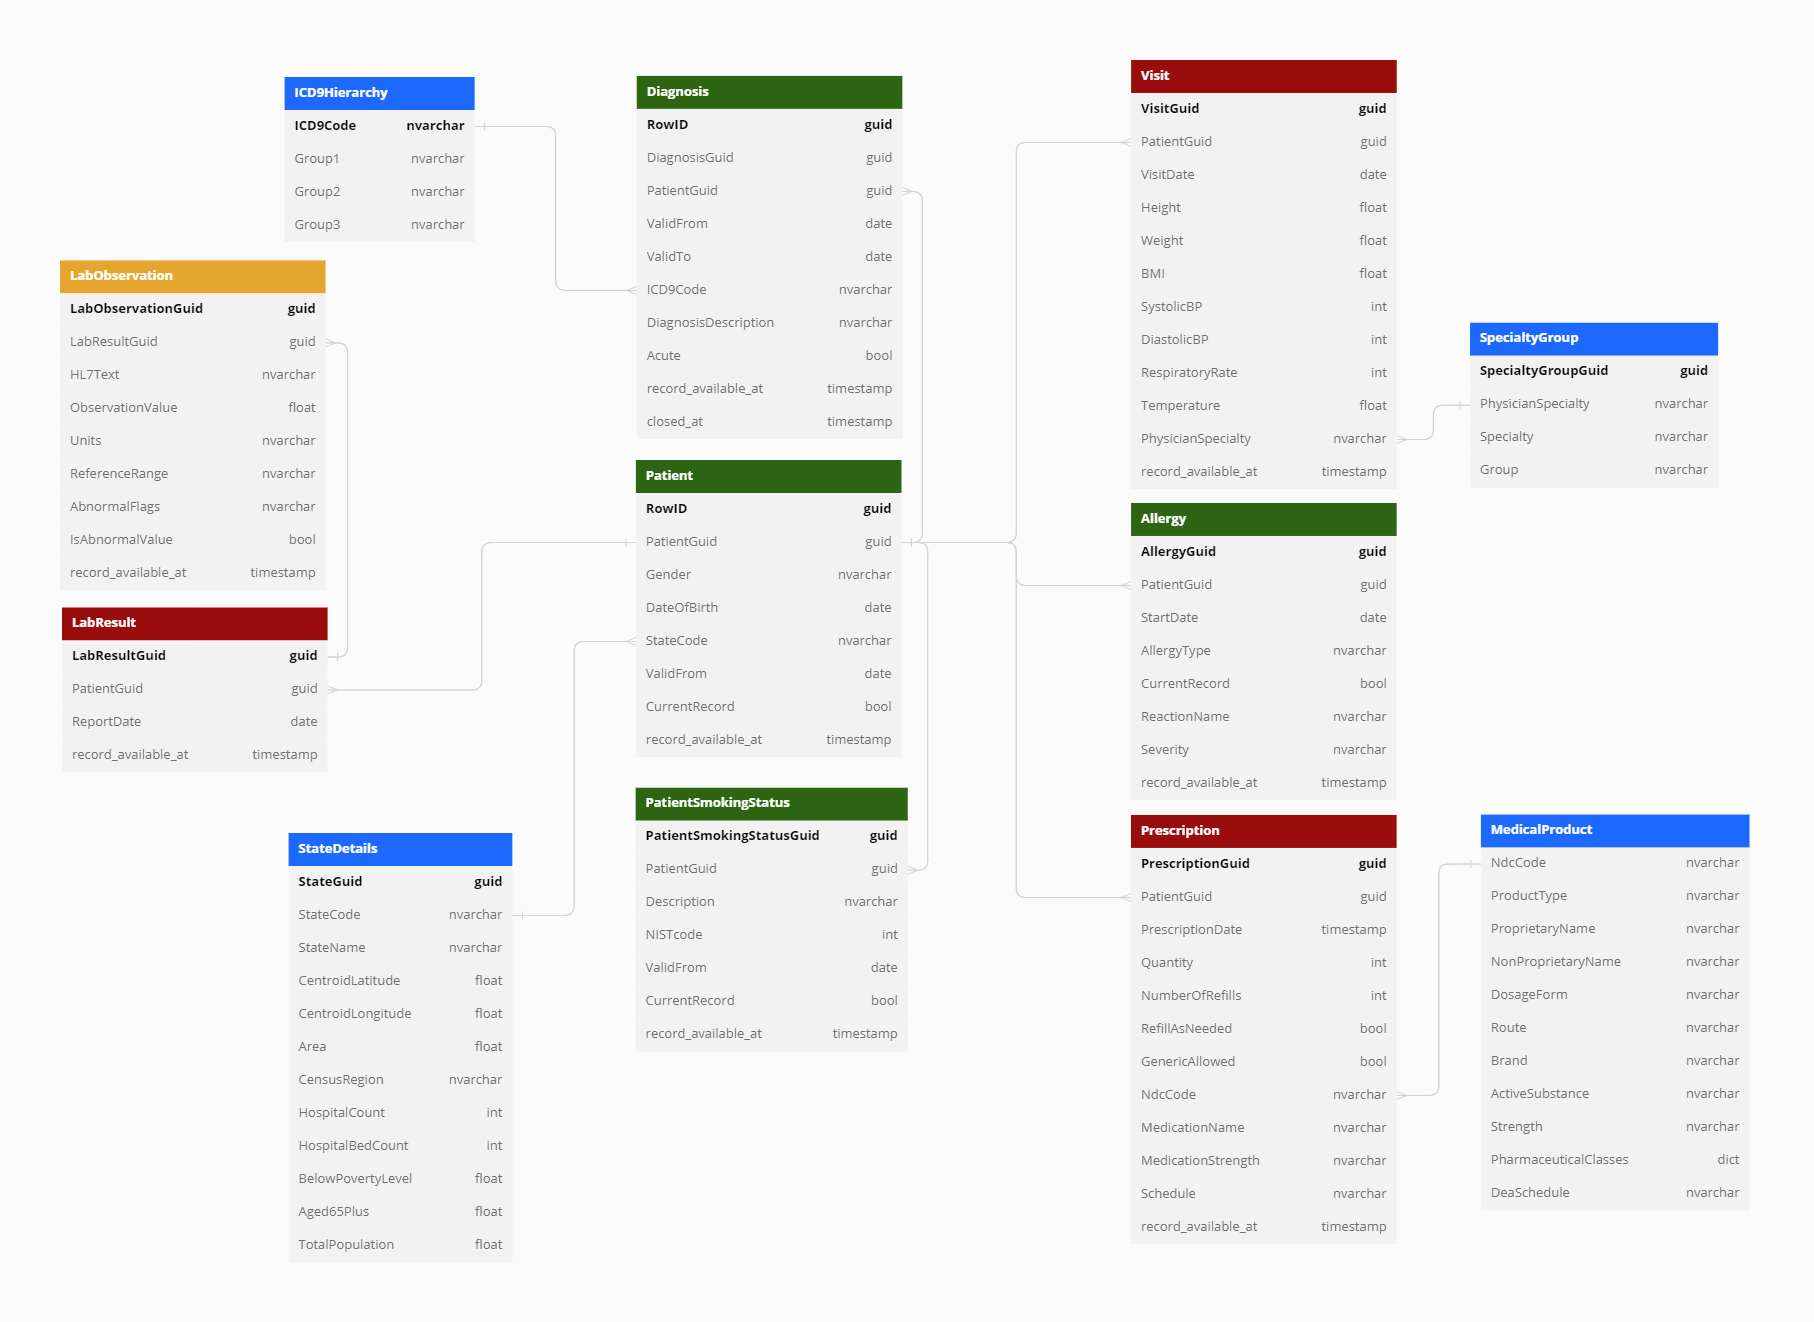
